# Projeto: NPL Análise de Sentimentos

Este é um projeto end-to-end de Natural Processing Language para analisar sentimentos relacionados a reviews do site IMDb.

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Foi disponibilizado um conjunto de dados de resenhas de filmes do IMDb com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. O modelo precisará ter um valor F1 de pelo menos 0.85.

## Inicialização

In [1]:
# Importando bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 

import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
from sklearn.model_selection import GridSearchCV

from tqdm.auto import tqdm

In [2]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...


True

In [3]:
#Setando o estilo e cor dos gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")
colors = ['#005780', '#00AEFF', '#80D7FF']
sns.set_palette(sns.color_palette(colors))

In [4]:
tqdm.pandas()

## Carregando dados

In [5]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [6]:
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


**Descrição dos campos de interesse:**

* **<em>'review':</em>** o texto da resenha

* **<em>'pos:</em>** o objetivo, '0' para negativo e '1' para positivo

* **<em>'ds_part:</em>** 'train'/'test' para a parte de treinamento/teste do conjunto de dados, respectivamente

### Conhecendo os dados

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [9]:
df_reviews.shape

(47331, 17)

In [10]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [11]:
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(df_reviews['average_rating'].median())
df_reviews['average_rating'].isna().sum()

0

In [12]:
df_reviews['votes'] = df_reviews['votes'].fillna(df_reviews['votes'].median())
df_reviews['votes'].isna().sum()

0

In [13]:
df_reviews.duplicated().sum()

0

### Percepções iniciais sobre o dataset

* Os dados representam um conjunto de características de revisões de filmes, curtas, programas televisivos e jogos, compartilhados pela audiência do site IMDb.


* O dataframe conta com 47.331 registros, entretanto apresentava valores ausentes nas features 'average_rating' e 'votes' que foram substituídos pela sua respectiva mediana. Não existe conteúdo duplicado.


* O conjunto de dados abrange filmes do ano de 1894 a 2010.


* A maior parte dos filmes não possuem conteúdo adulto, conforme indicado pelo valor médio próximo a 0.


* A qualidade geral média atribuída a cada título ('average_rating') no conjunto de dados é de aproximadamente 5,998, com um desvio padrão de 1,494. A classificação mínima é 1,4 e a máxima é 9,7. 


* O conjunto de dados tem uma média de aproximadamente 25.562 votos ('votes') por título (média). O desvio padrão é relativamente alto, indicando uma ampla gama de contagens de votos.


* A classificão do filme, que pode variar de 1 a 10, tem valor médio de aproximadamente 5,485, indicando uma distribuição relativamente equilibrada de classificações. O desvio padrão é 3,473, mostra alguma variabilidade nas classificações.


* Em relação a polaridade dos sentimentos nas reviews ('pos') o valor médio de 0,499 indica que aproximadamente metade das avaliações são classificadas como positivas. O desvio padrão é próximo de 0,5, sugerindo uma distribuição relativamente equilibrada entre avaliações positivas e negativas.

## AED

### Número de filmes e resenhas por décadas

Ao agrupar os filmes pela sua década correspondente conseguimos obter uma representação gráfica melhor.

In [14]:
df_reviews['decade_start_year'] = df_reviews['start_year'].apply(lambda year: (year // 10) * 10)

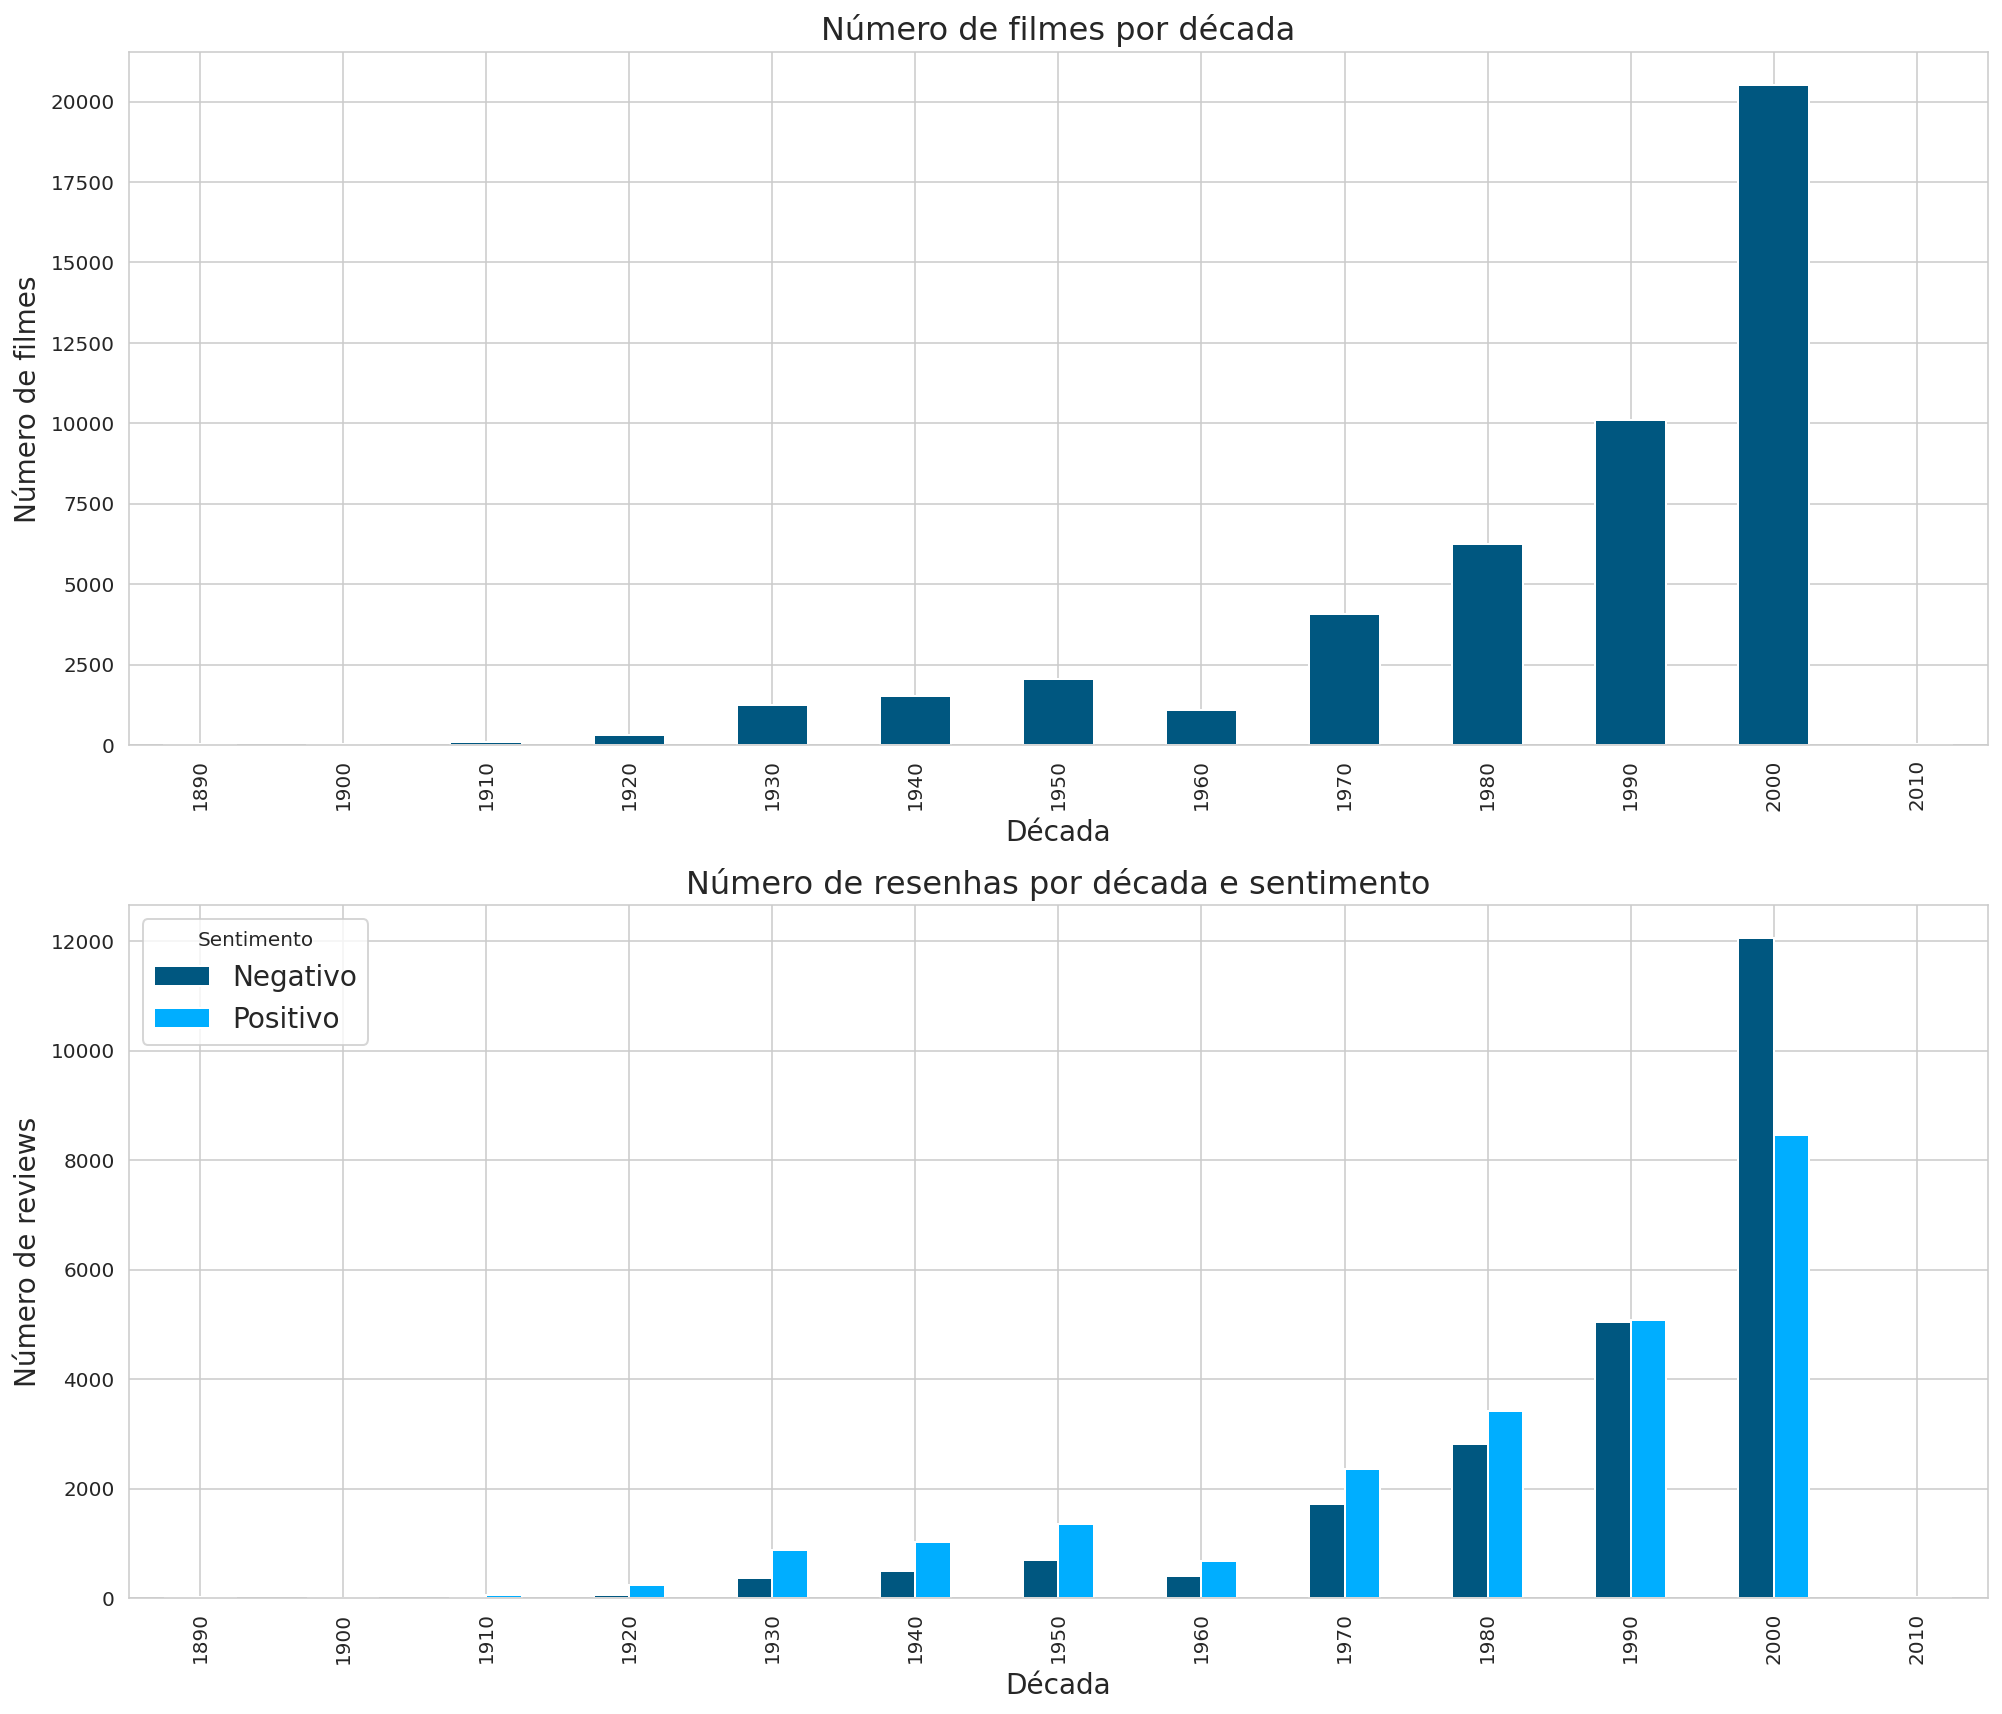

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Número de filmes por década
ax = axs[0]
dft1 = df_reviews['decade_start_year'].value_counts().sort_index()
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes por década', fontsize=16)
ax.set_xlabel('Década', fontsize=14)
ax.set_ylabel('Número de filmes', fontsize=14)

# Números de reviewspor década and sentimento
ax = axs[1]
dft2 = df_reviews.groupby(['decade_start_year', 'pos'])['pos'].count().unstack()
dft2.plot(kind='bar', ax=ax)
ax.set_title('Número de resenhas por década e sentimento', fontsize=16)
ax.set_xlabel('Década', fontsize=14)
ax.set_ylabel('Número de reviews', fontsize=14)
ax.legend(['Negativo', 'Positivo'], title='Sentimento', fontsize=14)

fig.tight_layout()
plt.show()

**Conclusões**

Vemos que o número de reviews aumentam a patir dos filmes da década de 30 e tem maior número nos anos 2000.Com relação ao tipo de reviews vemos que a quantidade de reviews negativas e positivas são próximas, entretanto nos anos 2000 houve um aumento expressivo de reviews negativas.

### Distribuição de reviews por filme

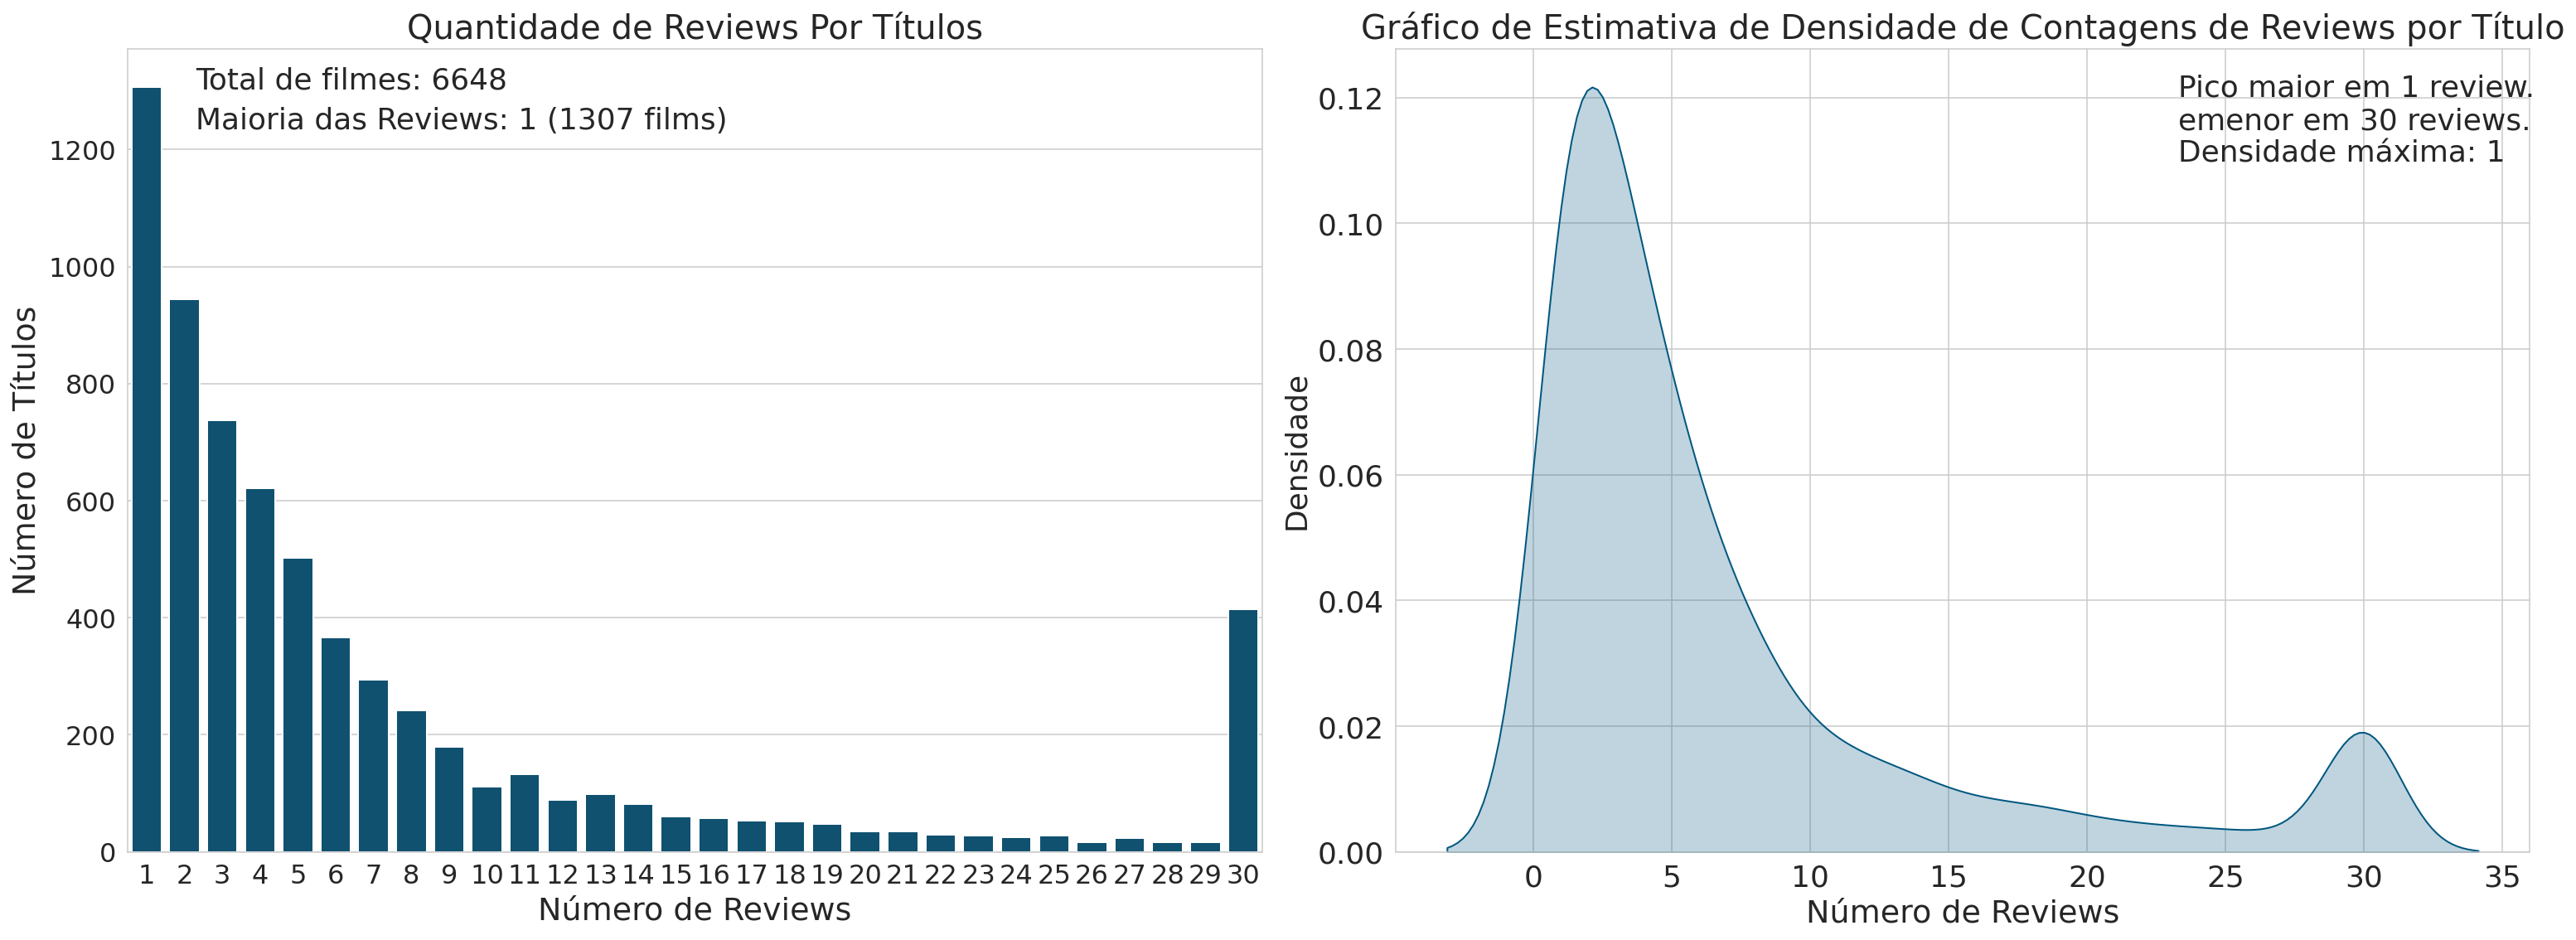

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count().value_counts().sort_index()
sns.barplot(x=dft.index, y=dft.values, ax=ax, color='#005780')
ax.set_title('Quantidade de Reviews Por Títulos', fontsize=20)
ax.set_xlabel('Número de Reviews', fontsize=19)
ax.set_ylabel('Número de Títulos', fontsize=19)
ax.tick_params(axis='both', which='major', labelsize=16)

total_films = len(df_reviews['tconst'].unique())
max_reviews = dft.idxmax()
max_review_count = dft.max()
ax.annotate(f"Total de filmes: {total_films}", xy=(0.06, 0.95), xycoords='axes fraction', fontsize=18)
ax.annotate(f"Maioria das Reviews: {max_reviews} ({max_review_count} films)", xy=(0.06, 0.9), xycoords='axes fraction', fontsize=18)

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax, fill=True)
ax.set_title('Gráfico de Estimativa de Densidade de Contagens de Reviews por Título', fontsize=20)
ax.set_xlabel('Número de Reviews', fontsize=19)
ax.set_ylabel('Densidade', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)

max_density = dft.value_counts().idxmax()

ax.annotate(f"Pico maior em 1 review.\nemenor em 30 reviews.", xy=(0.69, 0.9), xycoords='axes fraction', fontsize=18)
ax.annotate(f"Densidade máxima: {max_density}", xy=(0.69, 0.86), xycoords='axes fraction', fontsize=18)

fig.tight_layout()
plt.show()


**Conclusões**

A partir dos gráficos, podemos observar que a maioria dos filmes possui apenas uma review. Conforme o número de reviews aumenta, o número de filmes diminui, com exceção de aproximadamente 410 filmes que possuem 30 reviews. O gráfico de densidade indica uma consistência na distribuição entre os dois gráficos, com picos semelhantes ocorrendo nos mesmos valores de reviews que o gráfico de barras. Isso sugere que os filmes com uma única crítica são relativamente comuns, pois possuem uma densidade de probabilidade mais alta. Além disso, o gráfico de densidade também apresenta um pico menor em 30 reviews, em comparação com o gráfico de barras.

### Classificações dos títulos no conjuntos de treinamento e teste

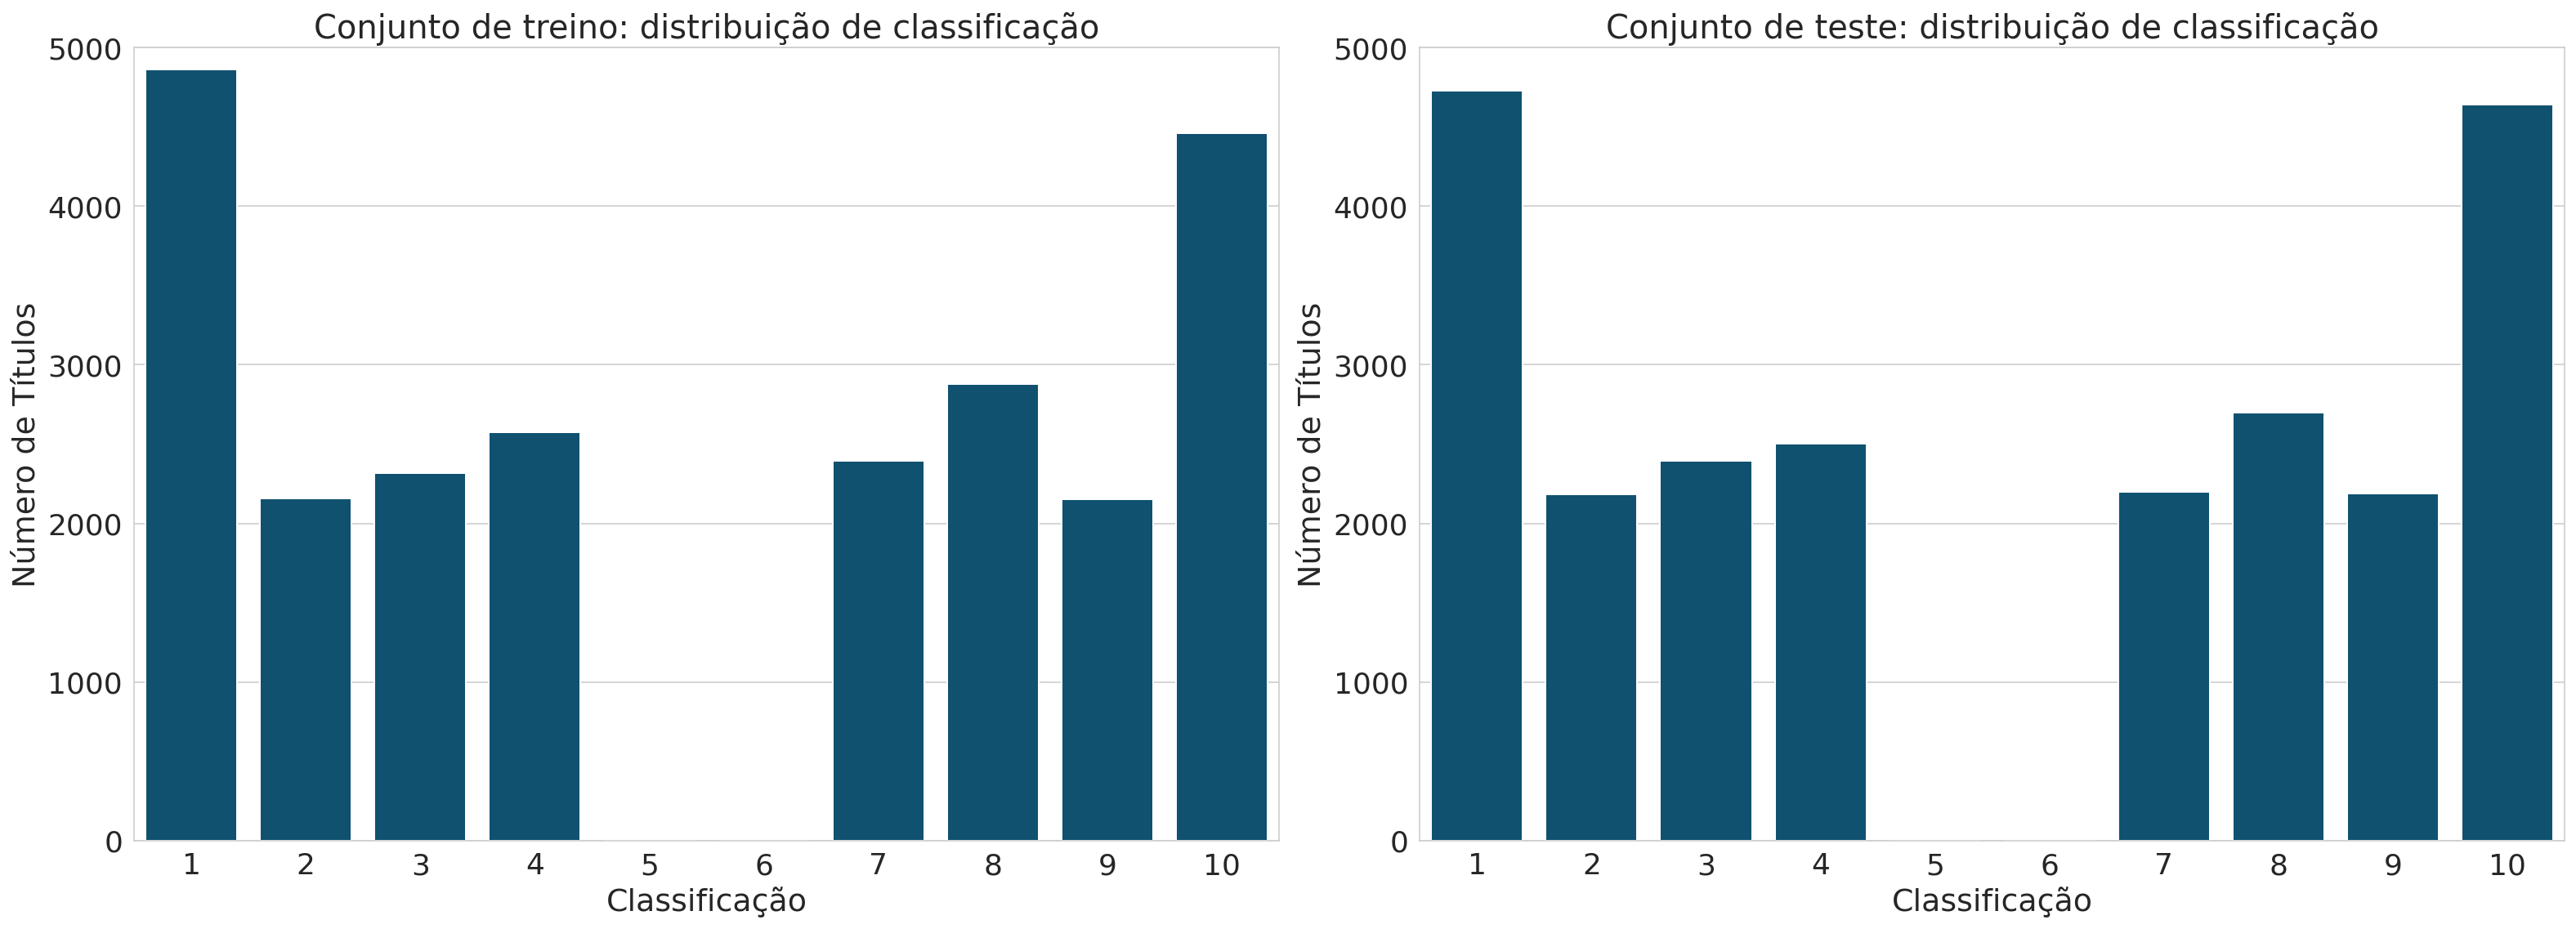

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(22, 8))

# Barplot para o conjunto de treino
ax = axs[0]
train_data = df_reviews[df_reviews['ds_part'] == 'train']
dft_train = train_data['rating'].value_counts().sort_index()
dft_train = dft_train.reindex(index=np.arange(min(dft_train.index.min(), 1), max(dft_train.index.max(), 11))).fillna(0)
sns.barplot(x=dft_train.index, y=dft_train.values, ax=ax, color='#005780')
ax.set_ylim([0, 5000])
ax.set_title('Conjunto de treino: distribuição de classificação', fontsize=20)
ax.set_xlabel('Classificação', fontsize=19)
ax.set_ylabel('Número de Títulos', fontsize=19)
ax.tick_params(axis='both', which='major', labelsize=18)

# Barplot para o conjunto de test
ax = axs[1]
test_data = df_reviews[df_reviews['ds_part'] == 'test']
dft_test = test_data['rating'].value_counts().sort_index()
dft_test = dft_test.reindex(index=np.arange(min(dft_test.index.min(), 1), max(dft_test.index.max(), 11))).fillna(0)
sns.barplot(x=dft_test.index, y=dft_test.values, ax=ax, color='#005780')
ax.set_ylim([0, 5000])
ax.set_title('Conjunto de teste: distribuição de classificação', fontsize=20)
ax.set_xlabel('Classificação', fontsize=19)
ax.set_ylabel('Número de Títulos', fontsize=19)
ax.tick_params(axis='both', which='major', labelsize=18)

fig.tight_layout()
plt.show()


**Conclusões**

No gráfico é possível ver que a avaliação dos filmes são semelhantes nos dois sets. No entanto o set de teste a quantidade de filmes com avaliação 1 e 10 é bastante próximo.

### Sentimentos entre as reviews nos dois conjuntos

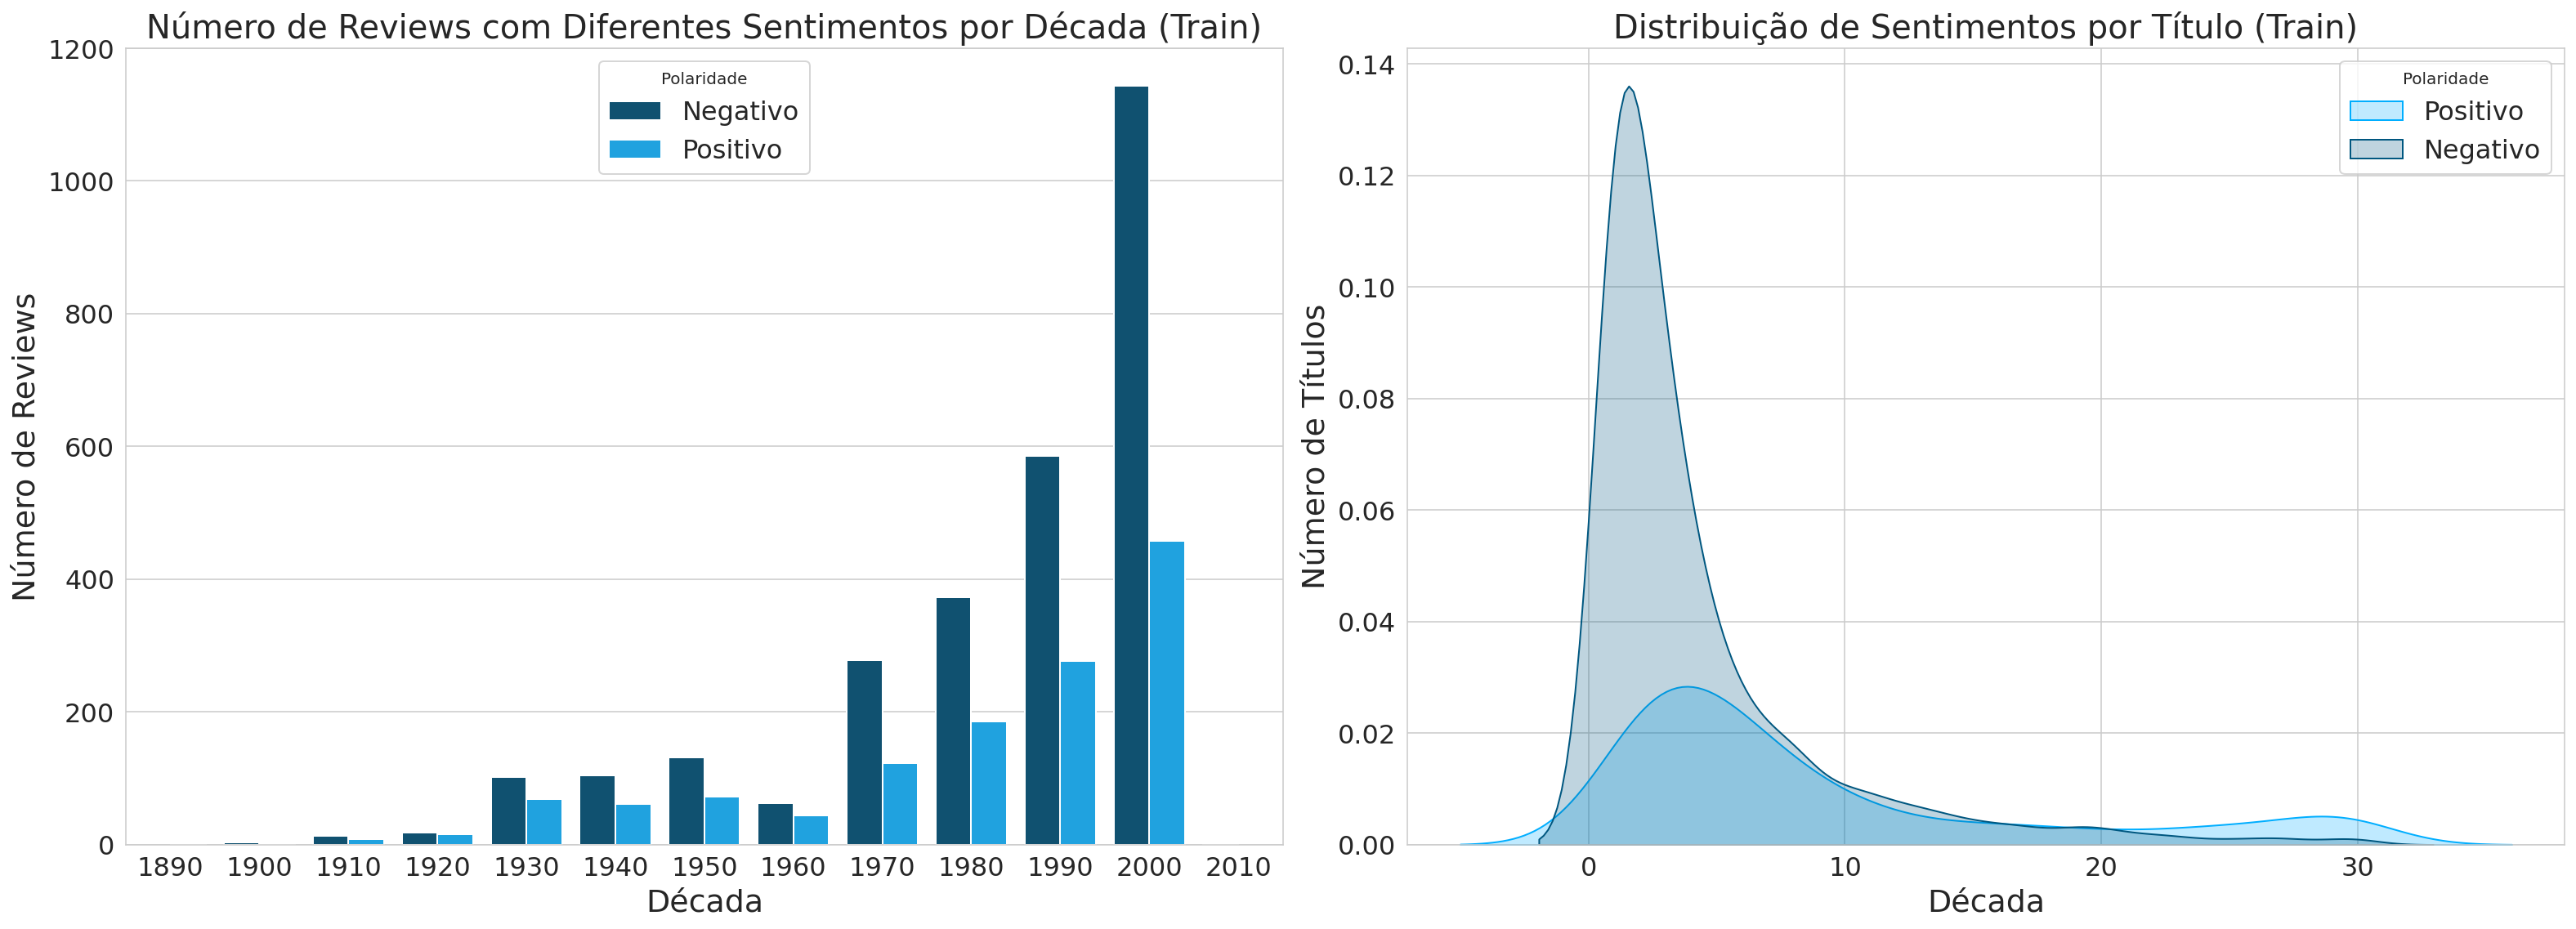

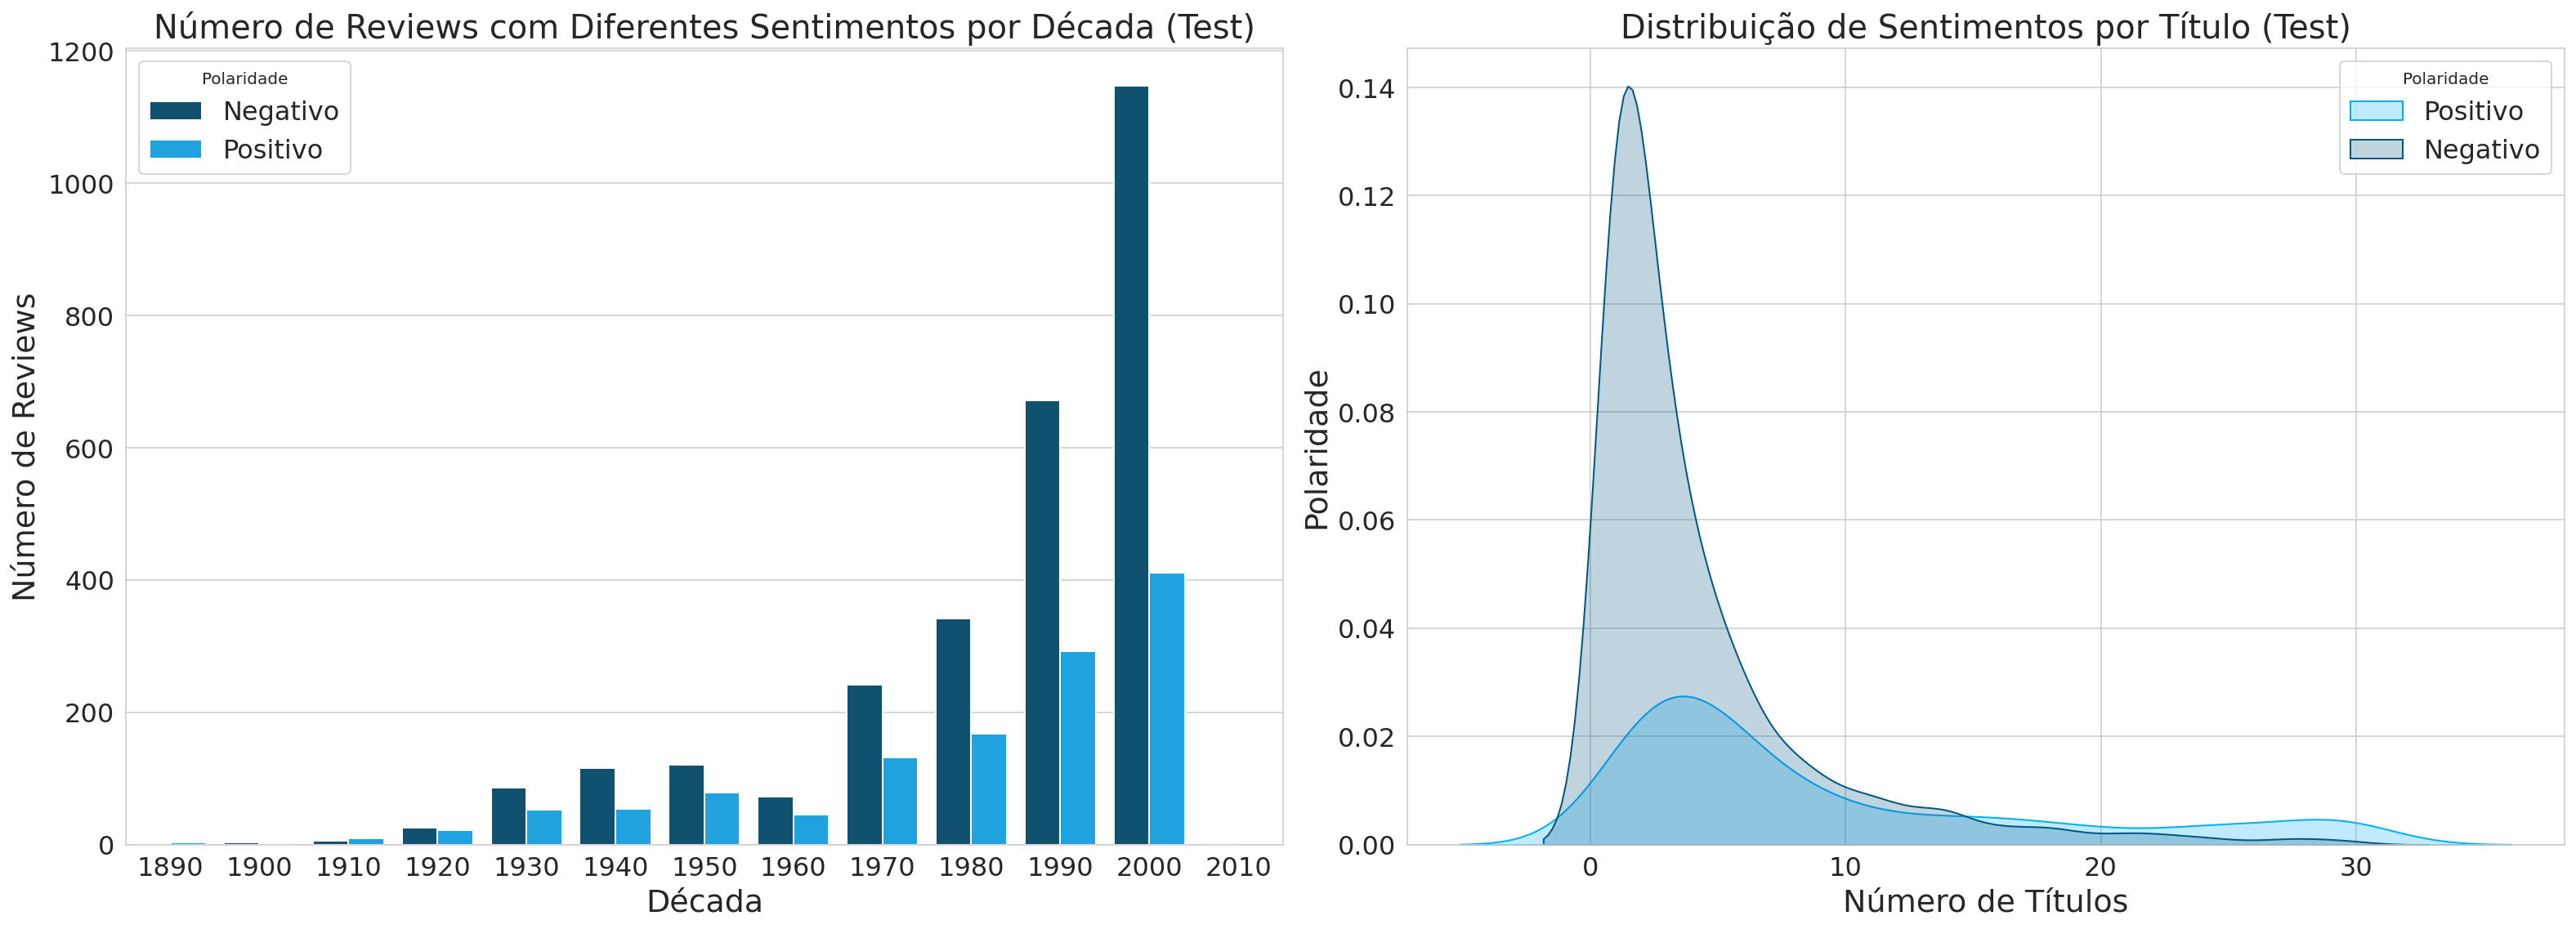

In [18]:
#----------------------------------------------------Train-----------------------------------------------------

# Filtrando dataframe pela coluna 'ds_part' == Train
df_train = df_reviews[df_reviews['ds_part'] == 'train']
df_train = df_train[['tconst', 'decade_start_year', 'pos']].value_counts().sort_index().reset_index(name='count')
df_train = df_train.reindex(index=np.arange(min(df_train.index.min(), 1), max(df_train.index.max(), 11))).fillna(0)

fig, axs_1 = plt.subplots(1, 2, figsize=(22, 8))

# Número de reviews por década e polaridade
ax = axs_1[0]
sns.countplot(data=df_train, x='decade_start_year', hue='pos', ax=ax)
ax.set_xlabel('Década', fontsize=19)
ax.set_ylabel('Número de Reviews', fontsize=19)
ax.set_title('Número de Reviews com Diferentes Sentimentos por Década (Train)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(['Negativo', 'Positivo'], title='Polaridade', fontsize=16)

# Distribuição das polaridades por filme
ax = axs_1[1]
sns.kdeplot(data=df_train, x='count', hue='pos', ax=ax, fill=True)
ax.set_xlabel('Década', fontsize=19)
ax.set_ylabel('Número de Títulos', fontsize=19)
ax.set_title('Distribuição de Sentimentos por Título (Train)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(['Positivo', 'Negativo'], title='Polaridade', fontsize=16)

fig.tight_layout()
plt.show()

#-------------------------------------------------------------------------------------------------------------

#----------------------------------------------------Test-----------------------------------------------------

# Filtrando dataframe pela coluna 'ds_part' == Test
df_test = df_reviews[df_reviews['ds_part'] == 'test']
df_test = df_test[['tconst', 'decade_start_year', 'pos']].value_counts().sort_index().reset_index(name='count')
df_test = df_test.reindex(index=np.arange(min(df_test.index.min(), 1), max(df_test.index.max(), 11))).fillna(0)

fig, axs_2 = plt.subplots(1, 2, figsize=(22, 8))

# Número de reviews por década e polaridade
ax = axs_2[0]
sns.countplot(data=df_test, x='decade_start_year', hue='pos', ax=ax)
ax.set_xlabel('Década', fontsize=19)
ax.set_ylabel('Número de Reviews', fontsize=19)
ax.set_title('Número de Reviews com Diferentes Sentimentos por Década (Test)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(['Negativo', 'Positivo'], title='Polaridade', fontsize=16)

# Distribuição das polaridades por filme
ax = axs_2[1]
sns.kdeplot(data=df_test, x='count', hue='pos', ax=ax, fill=True)
ax.set_xlabel('Número de Títulos', fontsize=19)
ax.set_ylabel('Polaridade', fontsize=19)
ax.set_title('Distribuição de Sentimentos por Título (Test)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(['Positivo', 'Negativo'], title='Polaridade', fontsize=16)

fig.tight_layout()
plt.show()


**Conclusões**

Nos gráficos acima é possível afirmar que há mais reviews negativas do que positivas nos dois conjuntos. No set completo o número de avaliações positivas foi um pouco maior, exceto para década de 2000. No gráfico de densidade as reviews negativas são as mais comuns.

### Conclusões gerais da etapa de AED

* **Polarização:** Pelos gráficos de barra em que a distribuição das classes de sentimentos (0-Negativo, 1-Positivo) mostra uma maior quantidade de reviews negativas quando os dados são separados por treino e teste. 


* **Contagens de resenhas e décadas:** o número de resenhas aumenta a partir dos filmes que começam na década de 1930 e atinge seu pico na década de 2000. Isso indica uma tendência de aumento da atividade de revisão ao longo do tempo, com um aumento significativo no número de revisões durante os anos 2000.


* **Distribuição dos Tipos de Críticas:** A quantidade de críticas negativas e positivas é relativamente próxima, indicando uma distribuição equilibrada entre as duas polaridades. No entanto, há um aumento notável nas críticas negativas durante os anos 2000, sugerindo uma mudança de sentimento durante esse período.


* **Maioria dos filmes com crítica única:** a maioria dos filmes no conjunto de dados tem apenas uma crítica. À medida que aumenta o número de resenhas, diminui o número de filmes, com exceção de um grupo específico de aproximadamente 410 filmes que contam com 30 resenhas. Esse padrão é evidente tanto no gráfico de barras quanto no gráfico de densidade. Os picos no gráfico de densidade ocorrem em valores de contagem de revisão semelhantes aos do gráfico de barras, indicando que os filmes com uma única revisão são relativamente comuns e têm uma densidade de probabilidade mais alta. Além disso, o gráfico de densidade exibe um pico menor em 30 avaliações em comparação com o gráfico de barras.


* **Semelhança entre os conjuntos de treinamento e teste:** os gráficos que descrevem o número de revisões por década e a polaridade revelam que a distribuição de revisões é semelhante nos conjuntos de treinamento e teste. No entanto, no conjunto de teste, há um número comparável de filmes com classificações de 1 e 10.


* **Críticas negativas mais altas:** Ambos os conjuntos, treino e teste, mostram uma ocorrência maior de críticas negativas em comparação com críticas positivas. No conjunto de dados completo, há um maior número de críticas positivas, exceto durante os anos 2000. O gráfico de densidade também destaca que as críticas negativas são mais comuns do que as críticas positivas.

## Preparando os dados

### Feature Engineering

#### Lematização e tozenização

A tokenização irá dividir as reviews em unidades significativas, chamadas tokens, criando um array de palavras. Já a lematização irá reduzir as palavras flexionadas ou conjugadas à sua forma base(lema).   O obetivo é estruturar e normalizar os dados textuais para que os algoritimos dos modelos de NPL possam analisá-los.

In [19]:
# Instancionando os objetos 
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
# Retirando as palavras que não possuem um significado semântico distinto  
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Essa função irá lematizar o texto
def lemmatize(text):
    doc = nlp(text.lower())
    lemmas = []
    for word in doc:
        lemmas.append(word.lemma_)
    lemmas = " ".join(lemmas)
    return lemmas

#  Esssa função irá pegar os resultados da função lemmatize e aplicar a tokenização
def tokenize(lemmas):
    tokens = word_tokenize(lemmas)
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.isalpha()]
    return tokens

In [20]:
df_reviews['review_lem'] = df_reviews['review'].progress_apply(lambda x: tokenize(x))

  0%|          | 0/47331 [00:00<?, ?it/s]

#### Léxicos de sentimento

Aqui o objeto sia irá analisar a intensidade dos sentimentos, com base na biblioteca de sentimentos VADER, e retornar um dicionário de números contínuos entre -1 a 1. Quanto mais próximo de -1, mais negativo é o sentimento. Quanto mais próximo de 1, mais positivo é o sentimento e valores próximos a 0 indicam um sentimento neutro.

In [21]:
sia = SentimentIntensityAnalyzer()
df_reviews['sentiment_scores'] = df_reviews['review_lem'].progress_apply(lambda x: sia.polarity_scores(' '.join(x)))

  0%|          | 0/47331 [00:00<?, ?it/s]

In [22]:
''' 
    Para facilitar a utilização da intensidade dos sentimentos irei criar uma função que irá comparar os 
    valores de sentimentos negativos e positivos e retornar 1 ou -1 a depender da proximidade desses valores.
    No caso de valores neutros irá retornar 0.
    
    '''

def encode_sentiment(sentiment_dict):
    if sentiment_dict['pos'] > sentiment_dict['neg']:
        return 1
    elif sentiment_dict['neg'] > sentiment_dict['pos']:
        return -1
    else:
        return 0

# Aplicando a função em uma nova coluna do DataFrame
df_reviews['sentiment_encoded'] = df_reviews['sentiment_scores'].apply(encode_sentiment)


#### Criando codificação para gêneros dos títulos

Para facilitar a análise de features pelo modelo.

In [23]:
# Creando lista de gêneros unicos
unique_genres = set()

# Extraindo gêneros unicos
for genres in df_reviews['genres']:
    unique_genres.update(genres.split(','))

# Criaando indicador binário para cada gênero
for genre in unique_genres:
    df_reviews[genre] = df_reviews['genres'].apply(lambda x: int(genre in x))


#### Calculando a idade de cada título

In [24]:
current_year =  datetime.datetime.now().year
df_reviews['age_title'] = current_year - df_reviews['start_year']

#### Filtrando dataset pelas colunas de interesse

In [25]:
df_reviews_clean = df_reviews[['runtime_minutes', 'average_rating',
       'votes', 'rating','pos', 'ds_part', 'idx',
       'decade_start_year', 'review_lem', 'sentiment_encoded', 
        'Documentary', 'Drama', 'Sport', 'Talk-Show',
       'Action', 'Mystery', 'Musical', 'Sci-Fi', 'Reality-TV',
       'Animation', 'Family', 'History', 'Comedy', 'Adventure', 'Thriller',
       'News', 'Western', 'War', 'Biography', 'Game-Show', 'Fantasy', 'Music',
       'Horror', 'Adult', 'Crime', 'Romance', 'Film-Noir', 'Short',
       'age_title']]

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [26]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    # Calculate predictions and probabilities for the training set
    train_pred_proba = model.predict_proba(train_features)[:, 1]

    # Calculate predictions and probabilities for the test set
    test_pred_proba = model.predict_proba(test_features)[:, 1]

    # Evaluation metrics for the training set
    train_metrics = {
        'Train Precision': precision_score(train_target, model.predict(train_features)),
        'Train Recall': recall_score(train_target, model.predict(train_features)),
        'Train F1-score': f1_score(train_target, model.predict(train_features))
    }

    # Evaluation metrics for the test set
    test_metrics = {
        'Test Precision': precision_score(test_target, model.predict(test_features)),
        'Test Recall': recall_score(test_target, model.predict(test_features)),
        'Test F1-score': f1_score(test_target, model.predict(test_features))
    }

    # Print evaluation metrics for the training set
    print("Evaluation Metrics - Training Set:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.2f}")

    # Print evaluation metrics for the test set
    print("\nEvaluation Metrics - Test Set:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.2f}")
        
    return None

## Separando os conjuntos de treinamento e teste

In [27]:
#Filtrando o dataframe por ds_part para encontrar conjunto de treino e de teste
df_train = df_reviews_clean[df_reviews['ds_part'] == 'train'].copy()
df_test = df_reviews_clean[df_reviews['ds_part'] == 'test'].copy()

df_reviews_train = df_train.drop('pos', axis=1)
df_reviews_test = df_test.drop('pos', axis=1)

train_target = df_train['pos']
test_target = df_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape) 

(23796, 38)
(23535, 38)


## Normalizando variáveis numéricas 

In [28]:
# Definir as colunas numéricas
numeric_cols = ['rating', 'votes', 'age_title']

# Criar uma instância do StandardScaler
scaler = StandardScaler()

# Aplicar o StandardScaler nas colunas numéricas
df_reviews_train[numeric_cols] = scaler.fit_transform(df_reviews_train[numeric_cols])
df_reviews_test[numeric_cols] = scaler.transform(df_reviews_test[numeric_cols])


## Treino e teste dos modelos

### Regressão Logística

In [29]:
# Transformando os dados de treinamento e teste em texto
corpus_train = [' '.join(review) for review in df_reviews_train['review_lem']]
corpus_test = [' '.join(review) for review in df_reviews_test['review_lem']]

# Aplicando TF-IDF nos dados de treinamento e teste 
vectorizer_model_lr = TfidfVectorizer(stop_words='english')
df_train_lr = vectorizer_model_lr.fit_transform(corpus_train)
df_test_lr = vectorizer_model_lr.transform(corpus_test)

# Treinando o modelo
model_lr = LogisticRegression(C=1, penalty='l2', max_iter=500)
model_lr_fit = model_lr.fit(df_train_lr, train_target)

# Avaliando o modelo
evaluate_model(model_lr, df_train_lr, train_target, df_test_lr, test_target)

Evaluation Metrics - Training Set:
Train Precision: 0.93
Train Recall: 0.95
Train F1-score: 0.94

Evaluation Metrics - Test Set:
Test Precision: 0.88
Test Recall: 0.88
Test F1-score: 0.88


### Light Gradient-Boosting Machine (LGBM)

In [30]:
# Transformando os dados de treinamento e teste em texto
corpus_train = [' '.join(review) for review in df_reviews_train['review_lem']]
corpus_test = [' '.join(review) for review in df_reviews_test['review_lem']]

# Aplicando TF-IDF nos dados de treinamento e teste 
vectorizer_model_lgbm = TfidfVectorizer(stop_words='english')
df_train_lgbm = vectorizer_model_lgbm.fit_transform(corpus_train)
df_test_lgbm = vectorizer_model_lgbm.transform(corpus_test)

# Treinando modelo
model_lgbm = LGBMClassifier()
model_lgbm_fit= model_lgbm.fit(df_train_lgbm, train_target)

# Avaliando o modelo
evaluate_model(model_lgbm, df_train_lgbm, train_target, df_test_lgbm, test_target)


Evaluation Metrics - Training Set:
Train Precision: 0.90
Train Recall: 0.93
Train F1-score: 0.91

Evaluation Metrics - Test Set:
Test Precision: 0.84
Test Recall: 0.87
Test F1-score: 0.86


### XGBoost (XGB)

In [31]:
import xgboost as xgb
corpus_train = [' '.join(review) for review in df_reviews_train['review_lem']]
corpus_test = [' '.join(review) for review in df_reviews_test['review_lem']]

vectorizer_model_xgb = TfidfVectorizer(stop_words='english')
df_train_xgb = vectorizer_model_xgb.fit_transform(corpus_train)
df_test_xgb = vectorizer_model_xgb.transform(corpus_test)

model_xgb = xgb.XGBClassifier(eval_metric='error', use_label_encoder=False)
model_xgb_fit = model_xgb.fit(df_train_xgb, train_target)
evaluate_model(model_xgb, df_train_xgb, train_target, df_test_xgb, test_target)

Evaluation Metrics - Training Set:
Train Precision: 0.92
Train Recall: 0.96
Train F1-score: 0.94

Evaluation Metrics - Test Set:
Test Precision: 0.83
Test Recall: 0.87
Test F1-score: 0.85


### Conclusões gerais da etapa de treinamento e teste dos modelos

Nos resultados acima temos 3 métricas precisão, recall e score F1:

* A **precisão** é capaz de medir a exatidão geral das previsões do modelo. É a taxa entre os positivos identificados corretamente (verdadeiros positivos).

* A métrica **recall** mede a relação entre as previsões positivas realizadas corretamente e todas as previsões que realmente são positivas.

* O **score/pontuação F1** é a média harmônica de precisão e recall, ou seja é uma métrica que equilibra as duas métricas. 
  
Com base nisso, podemos ver que todos os três modelos (Regreção Logística, LGBM e XGBoost) tiveram desempenho bastante semelhante no conjunto de teste, com pontuações de F1 em torno de 0,86-0,88. O modelo de Regressão Logística tem um desempenho um pouco melhor com uma pontuação F1 de 0,88 no conjunto de teste. No entanto, vale a pena notar que os modelos LGBM e XGBoost têm maior precisão e recall no conjunto de treinamento, indicando uma generalização potencialmente melhor.

## Testando o modelo com algumas resenhas

In [32]:
my_reviews = pd.DataFrame([
        'I simply didn\'t enjoy it; it\'s not my type of movie.',
        'Well, I became bored and fell asleep during the movie.',
        'I was genuinely fascinated by the film.',
        'The actors appeared very old and disinterested, yet they were still paid to participate in the film. What a shameless waste of money.',
        'I didn\'t anticipate the new version to be this good! The writers truly cared about the source material.',
        'The film has its strengths and weaknesses, but overall, it\'s a decent film. I can even envision myself watching it again.',
        'What a terrible attempt at comedy. Not a single joke lands, everyone acts irritatingly and loudly, even kids wouldn\'t enjoy it!',
        'Releasing it on Netflix was a bold move, and I genuinely appreciate being able to watch episode after episode of this thrilling and intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].progress_apply(lambda x: tokenize(x))

my_reviews


  0%|          | 0/8 [00:00<?, ?it/s]

,review,review_norm
0,I simply didn't enjoy it; it's not my type of ...,"[simply, enjoy, type, movie]"
1,"Well, I became bored and fell asleep during th...","[well, became, bored, fell, asleep, movie]"
2,I was genuinely fascinated by the film.,"[genuinely, fascinated, film]"
3,The actors appeared very old and disinterested...,"[actors, appeared, old, disinterested, yet, st..."
4,I didn't anticipate the new version to be this...,"[anticipate, new, version, good, writers, trul..."
5,"The film has its strengths and weaknesses, but...","[film, strengths, weaknesses, overall, decent,..."
6,What a terrible attempt at comedy. Not a singl...,"[terrible, attempt, comedy, single, joke, land..."
7,"Releasing it on Netflix was a bold move, and I...","[releasing, netflix, bold, move, genuinely, ap..."


Tomando como base o limiar de classificação padrão para classificações binárias de 0.5, podemos classificar os modelos a partir do seu score.

In [33]:
def predict_reviews(vectorizer, model):
    reviews = [' '.join(review) for review in my_reviews['review_norm']]
    vectorized_reviews = vectorizer.transform(reviews)
    pred_prob = model.predict_proba(vectorized_reviews)[:, 1]
    
    for i, review in enumerate(reviews[:len(my_reviews)]):
        score = pred_prob[i]
        classification = 'Positive' if score >= 0.5 else 'Negative'
        
        print(f'Text: {review}')
        print(f'Review {i+1}:')
        print(f'Score: {score:.2f}')
        print(f'Classification: {classification}\n')

    return None

### Regressão Logística

In [34]:
predict_reviews(vectorizer_model_lr, model_lr_fit)

Text: simply enjoy type movie
Review 1:
Score: 0.68
Classification: Positive

Text: well became bored fell asleep movie
Review 2:
Score: 0.07
Classification: Negative

Text: genuinely fascinated film
Review 3:
Score: 0.66
Classification: Positive

Text: actors appeared old disinterested yet still paid participate film shameless waste money
Review 4:
Score: 0.03
Classification: Negative

Text: anticipate new version good writers truly cared source material
Review 5:
Score: 0.34
Classification: Negative

Text: film strengths weaknesses overall decent film even envision watching
Review 6:
Score: 0.54
Classification: Positive

Text: terrible attempt comedy single joke lands everyone acts irritatingly loudly even kids would enjoy
Review 7:
Score: 0.09
Classification: Negative

Text: releasing netflix bold move genuinely appreciate able watch episode episode thrilling intelligent new drama
Review 8:
Score: 0.88
Classification: Positive



### Light Gradient-Boosting Machine

In [35]:
predict_reviews(vectorizer_model_lgbm, model_lgbm_fit)

Text: simply enjoy type movie
Review 1:
Score: 0.70
Classification: Positive

Text: well became bored fell asleep movie
Review 2:
Score: 0.34
Classification: Negative

Text: genuinely fascinated film
Review 3:
Score: 0.63
Classification: Positive

Text: actors appeared old disinterested yet still paid participate film shameless waste money
Review 4:
Score: 0.05
Classification: Negative

Text: anticipate new version good writers truly cared source material
Review 5:
Score: 0.65
Classification: Positive

Text: film strengths weaknesses overall decent film even envision watching
Review 6:
Score: 0.65
Classification: Positive

Text: terrible attempt comedy single joke lands everyone acts irritatingly loudly even kids would enjoy
Review 7:
Score: 0.09
Classification: Negative

Text: releasing netflix bold move genuinely appreciate able watch episode episode thrilling intelligent new drama
Review 8:
Score: 0.68
Classification: Positive



### XGBoost

In [36]:
predict_reviews(vectorizer_model_xgb, model_xgb_fit)

Text: simply enjoy type movie
Review 1:
Score: 0.64
Classification: Positive

Text: well became bored fell asleep movie
Review 2:
Score: 0.34
Classification: Negative

Text: genuinely fascinated film
Review 3:
Score: 0.60
Classification: Positive

Text: actors appeared old disinterested yet still paid participate film shameless waste money
Review 4:
Score: 0.08
Classification: Negative

Text: anticipate new version good writers truly cared source material
Review 5:
Score: 0.61
Classification: Positive

Text: film strengths weaknesses overall decent film even envision watching
Review 6:
Score: 0.60
Classification: Positive

Text: terrible attempt comedy single joke lands everyone acts irritatingly loudly even kids would enjoy
Review 7:
Score: 0.15
Classification: Negative

Text: releasing netflix bold move genuinely appreciate able watch episode episode thrilling intelligent new drama
Review 8:
Score: 0.60
Classification: Positive



### Conclusão da etapa de teste com uma pequena amostra de reviews

Como o número de reviews é pequeno podemos classificá-los e compará-los com os resultados dos modelos. UO resultado é a seguinte tabela:

<table>
  <thead>
    <tr>
      <th>Text Sentence</th>
      <th>Actual Sentiment</th>
      <th>Logistic Regression</th>
      <th>Correct</th>
      <th>LGBM</th>
      <th>Correct</th>
      <th>XGBoost</th>
      <th>Correct</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>I simply didn't enjoy it; it's not my type of movie.</td>
      <td>Negative</td>
      <td>Positive</td>
      <td>No</td>
      <td>Positive</td>
      <td>No</td>
      <td>Positive</td>
      <td>No</td>
    </tr>
    <tr>
      <td>Well, I became bored and fell asleep during the movie.</td>
      <td>Negative</td>
      <td>Negative</td>
      <td>Yes</td>
      <td>Negative</td>
      <td>Yes</td>
      <td>Negative</td>
      <td>Yes</td>
    </tr>
    <tr>
      <td>I was genuinely fascinated by the film.</td>
      <td>Positive</td>
      <td>Positive</td>
      <td>Yes</td>
      <td>Positive</td>
      <td>Yes</td>
      <td>Positive</td>
      <td>Yes</td>
    </tr>
    <tr>
      <td>The actors appeared very old and disinterested, yet they were still paid to participate in the film. What a shameless waste of money.</td>
      <td>Negative</td>
      <td>Negative</td>
      <td>Yes</td>
      <td>Negative</td>
      <td>Yes</td>
      <td>Negative</td>
      <td>Yes</td>
    </tr>
    <tr>
      <td>I didn't anticipate the new version to be this good! The writers truly cared about the source material.</td>
      <td>Positive</td>
      <td>Negative</td>
      <td>No</td>
      <td>Positive</td>
      <td>Yes</td>
      <td>Positive</td>
      <td>Yes</td>
    </tr>
    <tr>
      <td>The film has its strengths and weaknesses, but overall, it's a decent film. I can even envision myself watching it again.</td>
      <td>Positivo</td>
      <td>Positive</td>
      <td>Yes</td>
      <td>Positive</td>
      <td>Yes</td>
      <td>Positive</td>
      <td>Yes</td>
    </tr>
    <tr>
      <td>What a terrible attempt at comedy. Not a single joke lands, everyone acts irritatingly and loudly, even kids wouldn't enjoy it!</td>
      <td>Negative</td>
      <td>Negative</td>
      <td>Yes</td>
      <td>Negative</td>
      <td>Yes</td>
      <td>Negative</td>
      <td>Yes</td>
    </tr>
    <tr>
      <td>Releasing it on Netflix was a bold move, and I genuinely appreciate being able to watch episode after episode of this thrilling and intelligent new drama.</td>
      <td>Positive</td>
      <td>Positive</td>
      <td>Yes</td>
      <td>Positive</td>
      <td>Yes</td>
      <td>Positive</td>
      <td>Yes</td>
    </tr>
  </tbody>
  <tfoot>
    <tr>
      <td colspan="2">Total Correct</td>
      <td>6</td>
      <td></td>
      <td>7</td>
      <td></td>
      <td>7</td>
      <td></td>
    </tr>
    <tr>
      <td colspan="2">Accuracy Percentage</td>
      <td>75%</td>
      <td></td>
      <td>87.5%</td>
      <td></td>
      <td>87.5%</td>
      <td></td>
    </tr>
  </tfoot>
</table>


Podemos concluir com base nos resultados:

* Regressão Logística:
    * Porcentagem de respostas corretas: 75%
    * O modelo de Regressão Logística teve uma taxa de precisão ligeiramente inferior de 75%. Ele classificou corretamente 6 sentimentos de 8 sentenças.

* LGBM:
    * Porcentagem de respostas corretas: 87,5%
    * O modelo LGBM alcançou uma taxa de precisão de 87,5%. Ele classificou corretamente 7 sentimentos de 8 sentenças.

* XGBoost:
    * Porcentagem de respostas corretas: 87,5%
    * O modelo XGBoost também alcançou uma taxa de precisão geral de 87,5%. Ele classificou corretamente o sentimento da maioria das sentenças, com 7 de 8 sentenças sendo classificadas corretamente. 

No geral, os modelos de XGBoost e LGBM tiveram desempenho semelhante, atingindo uma taxa de precisão de 87,5%. Já o modelo Regressão Logistica teve uma taxa de precisão ligeiramente inferior de 75%. Esses resultados indicam que os modelos de gradient boosting forneceram um resultado com melhor precisão. 

## Conclusões

O conjunto de dados analisado consiste em revisões de filmes, curtas, programas televisivos e jogos do site IMDb, totalizando 47.331 registros. Para a análise desses dados, foram utilizados os modelos de Regressão Logística, LGBM e XGBoost, que apresentaram desempenho semelhante no conjunto de teste, com pontuações F1 em torno de 0,86-0,88.

Dentre os modelos, a Regressão Logística se destacou ligeiramente, obtendo uma pontuação F1 de 0,88 no conjunto de teste. No entanto, os modelos LGBM e XGBoost demonstraram uma melhor generalização, apresentando maior precisão e recall no conjunto de treinamento.

Os modelos LGBM e XGBoost tiveram um desempenho um pouco superior em termos de recall, enquanto a Regressão Logística teve um desempenho melhor em termos de precisão. Isso sugere que os primeiros modelos são mais eficientes na identificação de registros positivos, enquanto a Regressão Logística se destaca na detecção de registros negativos.

Mesmo em um pequeno conjunto de reviews, todos os modelos demonstraram um desempenho razoavelmente bom na detecção de avaliações negativas. Isso indica que os modelos são capazes de identificar adequadamente esse tipo de avaliação.